# DPU example: YOLOv3
----

## Aim/s
* This notebooks shows an example of DPU applications. The application,as well as the DPU IP, is pulled from the official 
[Vitis AI Github Repository](https://github.com/Xilinx/Vitis-AI).

## References
* [Vitis AI Github Repository](https://www.xilinx.com/products/design-tools/vitis/vitis-ai.html).

## Last revised
* Jun 27, 2022
    * Initial revision
----

## 1. Prepare the overlay
We will download the overlay onto the board. 

In [1]:
from pynq_dpu import DpuOverlay
overlay = DpuOverlay("dpu.bit")

## 2. Utility functions

In this section, we will prepare a few functions for later use.

In [2]:
import os
import time
import numpy as np
import cv2
import random
import colorsys
from pathlib import Path
import re
import csv
import pandas as pd
import numpy as np
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
%matplotlib inline

The `load_model()` method will automatically prepare the `graph`
which is used by VART.

**Note** For the KV260 board you may see TLS memory allocation errors if cv2 gets loaded before loading the vitis libraries in the Jupyter Lab environment. Make sure to load cv2 first in these cases.

In [4]:
overlay.load_model("fruit_model.xmodel")

Let's first define a few useful preprocessing functions.

In [26]:
anchor_list = [10,13,16,30,33,23,30,61,62,45,59,119,116,90,156,198,373,326]
anchor_float = [float(x) for x in anchor_list]
anchors = np.array(anchor_float).reshape(-1, 2)

In [27]:
'''Get model classification information'''	
def get_class(classes_path):
    with open(classes_path) as f:
        class_names = f.readlines()
    class_names = [c.strip() for c in class_names]
    return class_names
    
classes_path = "voc_classes.txt"
class_names = get_class(classes_path)
print(class_names)

['annona', 'apple', 'banana', 'guava', 'orange', 'pear', 'pineapple', 'pitaya']


In [28]:
num_classes = len(class_names)
hsv_tuples = [(1.0 * x / num_classes, 1., 1.) for x in range(num_classes)]
colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
colors = list(map(lambda x: 
                  (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), 
                  colors))
random.seed(0)
random.shuffle(colors)
random.seed(None)

In [29]:
'''resize image with unchanged aspect ratio using padding'''
def letterbox_image(image, size):
    ih, iw, _ = image.shape
    w, h = size
    scale = min(w/iw, h/ih)
    #print(scale)
    
    nw = int(iw*scale)
    nh = int(ih*scale)
    #print(nw)
    #print(nh)

    image = cv2.resize(image, (nw,nh), interpolation=cv2.INTER_LINEAR)
    new_image = np.ones((h,w,3), np.uint8) * 128
    h_start = (h-nh)//2
    w_start = (w-nw)//2
    new_image[h_start:h_start+nh, w_start:w_start+nw, :] = image
    return new_image
def pre_process_cam(image, model_image_size):
    if len(image.shape) != 3 or image.shape[2] != 3:
        raise ValueError("Invalid image shape")

    image_h, image_w, _ = image.shape
    image = image[..., ::-1]  # Reverse color channels

    if model_image_size != (None, None):
        assert model_image_size[0] % 32 == 0, 'Multiples of 32 required'
        assert model_image_size[1] % 32 == 0, 'Multiples of 32 required'
        boxed_image = letterbox_image(image, tuple(reversed(model_image_size)))
    else:
        new_image_size = (image_w - (image_w % 32), image_h - (image_h % 32))
        boxed_image = letterbox_image(image, new_image_size)

    image_data = np.array(boxed_image, dtype='float32')
    image_data /= 255.
    image_data = np.expand_dims(image_data, 0)     
    return image_data


def pre_process(image, model_image_size):
    image = image[...,::-1]
    image_h, image_w, _ = image.shape
 
    if model_image_size != (None, None):
        assert model_image_size[0]%32 == 0, 'Multiples of 32 required'
        assert model_image_size[1]%32 == 0, 'Multiples of 32 required'
        boxed_image = letterbox_image(image, tuple(reversed(model_image_size)))
    else:
        new_image_size = (image_w - (image_w % 32), image_h - (image_h % 32))
        boxed_image = letterbox_image(image, new_image_size)
    image_data = np.array(boxed_image, dtype='float32')
    image_data /= 255.
    image_data = np.expand_dims(image_data, 0) 	
    return image_data

We will also define a few functions to post-process the output after running a DPU task.

In [30]:
def _get_feats(feats, anchors, num_classes, input_shape):
    num_anchors = len(anchors)
    anchors_tensor = np.reshape(np.array(anchors, dtype=np.float32), [1, 1, 1, num_anchors, 2])
    grid_size = np.shape(feats)[1:3]
    nu = num_classes + 5
    predictions = np.reshape(feats, [-1, grid_size[0], grid_size[1], num_anchors, nu])
    grid_y = np.tile(np.reshape(np.arange(grid_size[0]), [-1, 1, 1, 1]), [1, grid_size[1], 1, 1])
    grid_x = np.tile(np.reshape(np.arange(grid_size[1]), [1, -1, 1, 1]), [grid_size[0], 1, 1, 1])
    grid = np.concatenate([grid_x, grid_y], axis = -1)
    grid = np.array(grid, dtype=np.float32)

    box_xy = (1/(1+np.exp(-predictions[..., :2])) + grid) / np.array(grid_size[::-1], dtype=np.float32)
    box_wh = np.exp(predictions[..., 2:4]) * anchors_tensor / np.array(input_shape[::-1], dtype=np.float32)
    box_confidence = 1/(1+np.exp(-predictions[..., 4:5]))
    box_class_probs = 1/(1+np.exp(-predictions[..., 5:]))
    return box_xy, box_wh, box_confidence, box_class_probs


def correct_boxes(box_xy, box_wh, input_shape, image_shape):
    box_yx = box_xy[..., ::-1]
    box_hw = box_wh[..., ::-1]
    input_shape = np.array(input_shape, dtype = np.float32)
    image_shape = np.array(image_shape, dtype = np.float32)
    new_shape = np.around(image_shape * np.min(input_shape / image_shape))
    offset = (input_shape - new_shape) / 2. / input_shape
    scale = input_shape / new_shape
    box_yx = (box_yx - offset) * scale
    box_hw *= scale

    box_mins = box_yx - (box_hw / 2.)
    box_maxes = box_yx + (box_hw / 2.)
    boxes = np.concatenate([
        box_mins[..., 0:1],
        box_mins[..., 1:2],
        box_maxes[..., 0:1],
        box_maxes[..., 1:2]
    ], axis = -1)
    boxes *= np.concatenate([image_shape, image_shape], axis = -1)
    return boxes


def boxes_and_scores(feats, anchors, classes_num, input_shape, image_shape):
    box_xy, box_wh, box_confidence, box_class_probs = _get_feats(feats, anchors, classes_num, input_shape)
    boxes = correct_boxes(box_xy, box_wh, input_shape, image_shape)
    boxes = np.reshape(boxes, [-1, 4])
    box_scores = box_confidence * box_class_probs
    box_scores = np.reshape(box_scores, [-1, classes_num])
    return boxes, box_scores

In [31]:
'''Draw detection frame'''
def draw_bbox(image, bboxes, classes):
    """
    bboxes: [x_min, y_min, x_max, y_max, probability, cls_id] format coordinates.
    """
    num_classes = len(classes)
    image_h, image_w, _ = image.shape
    hsv_tuples = [(1.0 * x / num_classes, 1., 1.) for x in range(num_classes)]
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), colors))

    random.seed(0)
    random.shuffle(colors)
    random.seed(None)

    for i, bbox in enumerate(bboxes):
        coor = np.array(bbox[:4], dtype=np.int32)
        fontScale = 0.5
        score = bbox[4]
        class_ind = int(bbox[5])
        bbox_color = colors[class_ind]
        bbox_thick = int(0.6 * (image_h + image_w) / 600)
        c1, c2 = (coor[0], coor[1]), (coor[2], coor[3])
        cv2.rectangle(image, c1, c2, bbox_color, bbox_thick)
    return image


def nms_boxes(boxes, scores):
    """Suppress non-maximal boxes.

    # Arguments
        boxes: ndarray, boxes of objects.
        scores: ndarray, scores of objects.

    # Returns
        keep: ndarray, index of effective boxes.
    """
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    areas = (x2-x1+1)*(y2-y1+1)
    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)

        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w1 = np.maximum(0.0, xx2 - xx1 + 1)
        h1 = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w1 * h1

        ovr = inter / (areas[i] + areas[order[1:]] - inter)
        inds = np.where(ovr <= 0.55)[0]  # threshold
        order = order[inds + 1]

    return keep

In [32]:
def draw_cam_boxes(image, boxes, scores, classes):
    _, ax = plt.subplots(1)
    if len(image.shape) == 2:
        # For grayscale images, add a third channel for visualization
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    else:
        # For BGR images (OpenCV default), convert to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax.imshow(image)
    image_h, image_w, _ = image.shape
    ax.set_xlim(0, image_w)  # 設置 x 軸範圍
    ax.set_ylim(image_h, 0)  # 設置 y 軸範圍

    for i, bbox in enumerate(boxes):
        [top, left, bottom, right] = bbox
        width, height = right - left, bottom - top
        center_x, center_y = left + width*0.5, top + height*0.5
        score, class_index = scores[i], classes[i]
        label = '{}: {:.4f}'.format(class_names[class_index], score) 
        color = tuple([color/255 for color in colors[class_index]])
        ax.add_patch(Rectangle((left, top), width, height,
                               edgecolor=color, facecolor='none'))
        ax.annotate(label, (center_x, center_y), color=color, weight='bold', 
                    fontsize=12, ha='center', va='center')
    return ax
def draw_boxes(image, boxes, scores, classes):
    _, ax = plt.subplots(1)
    ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    image_h, image_w, _ = image.shape

    for i, bbox in enumerate(boxes):
        [top, left, bottom, right] = bbox
        width, height = right - left, bottom - top
        center_x, center_y = left + width*0.5, top + height*0.5
        score, class_index = scores[i], classes[i]
        label = '{}: {:.4f}'.format(class_names[class_index], score) 
        color = tuple([color/255 for color in colors[class_index]])
        ax.add_patch(Rectangle((left, top), width, height,
                               edgecolor=color, facecolor='none'))
        ax.annotate(label, (center_x, center_y), color=color, weight='bold', 
                    fontsize=12, ha='center', va='center')
    return ax

In [33]:
def evaluate(yolo_outputs, image_shape, class_names, anchors):
    score_thresh = 0.2
    anchor_mask = [[6, 7, 8], [3, 4, 5], [0, 1, 2]]
    boxes = []
    box_scores = []
    input_shape = np.shape(yolo_outputs[0])[1 : 3]
    input_shape = np.array(input_shape)*32

    for i in range(len(yolo_outputs)):
        _boxes, _box_scores = boxes_and_scores(
            yolo_outputs[i], anchors[anchor_mask[i]], len(class_names), 
            input_shape, image_shape)
        boxes.append(_boxes)
        box_scores.append(_box_scores)
    boxes = np.concatenate(boxes, axis = 0)
    box_scores = np.concatenate(box_scores, axis = 0)

    mask = box_scores >= score_thresh
    boxes_ = []
    scores_ = []
    classes_ = []
    for c in range(len(class_names)):
        class_boxes_np = boxes[mask[:, c]]
        class_box_scores_np = box_scores[:, c]
        class_box_scores_np = class_box_scores_np[mask[:, c]]
        nms_index_np = nms_boxes(class_boxes_np, class_box_scores_np) 
        class_boxes_np = class_boxes_np[nms_index_np]
        class_box_scores_np = class_box_scores_np[nms_index_np]
        classes_np = np.ones_like(class_box_scores_np, dtype = np.int32) * c
        boxes_.append(class_boxes_np)
        scores_.append(class_box_scores_np)
        classes_.append(classes_np)
    boxes_ = np.concatenate(boxes_, axis = 0)
    scores_ = np.concatenate(scores_, axis = 0)
    classes_ = np.concatenate(classes_, axis = 0)

    return boxes_, scores_, classes_


Keep in mind that our original images are 640x480 so we need to preprocess them
later to make sure it fits our model.

In [107]:
import os
def rename_images(folder_path):
    # 列出資料夾中的所有檔案
    files = os.listdir(folder_path)
    # 設定新的檔名前綴或其他規則
    new_prefix = "sample_"
    counter = 1
    for file_name in files:
        old_path = os.path.join(folder_path, file_name)
        new_name = f"{new_prefix}{counter}.jpg"  # 根據需要更改檔名的格式
        new_path = os.path.join(folder_path, new_name)
        os.rename(old_path, new_path)
        counter += 1

In [109]:
image_folder = 'fruit'

rename_images(image_folder)
original_images = [i for i in os.listdir(image_folder)]
total_images = len(original_images)
print(total_images)
print(original_images)

57
['sample_47.jpg', 'sample_35.jpg', 'sample_56.jpg', 'sample_3.jpg', 'sample_45.jpg', 'sample_34.jpg', 'sample_1.jpg', 'sample_27.jpg', 'sample_42.jpg', 'sample_55.jpg', 'sample_14.jpg', 'sample_41.jpg', 'sample_53.jpg', 'sample_21.jpg', 'sample_26.jpg', 'sample_11.jpg', 'sample_36.jpg', 'sample_16.jpg', 'sample_43.jpg', 'sample_31.jpg', 'sample_57.jpg', 'sample_12.jpg', 'sample_54.jpg', 'sample_44.jpg', 'sample_5.jpg', 'sample_38.jpg', 'sample_10.jpg', 'sample_17.jpg', 'sample_13.jpg', 'sample_8.jpg', 'sample_32.jpg', 'sample_46.jpg', 'sample_29.jpg', 'sample_24.jpg', 'sample_9.jpg', 'sample_2.jpg', 'sample_48.jpg', 'sample_23.jpg', 'sample_19.jpg', 'sample_33.jpg', 'sample_30.jpg', 'sample_20.jpg', 'sample_15.jpg', 'sample_51.jpg', 'sample_40.jpg', 'sample_22.jpg', 'sample_37.jpg', 'sample_7.jpg', 'sample_25.jpg', 'sample_4.jpg', 'sample_28.jpg', 'sample_52.jpg', 'sample_18.jpg', 'sample_49.jpg', 'sample_6.jpg', 'sample_39.jpg', 'sample_50.jpg']


## 3. Use VART
Now we should be able to use VART to do image classification.

In [110]:
dpu = overlay.runner

In [111]:
inputTensors = dpu.get_input_tensors()

In [112]:
outputTensors = dpu.get_output_tensors()

In [113]:
shapeIn = tuple(inputTensors[0].dims)

In [114]:
shapeOut0 = (tuple(outputTensors[0].dims)) # (1, 13, 13, 75)
shapeOut1 = (tuple(outputTensors[1].dims)) # (1, 26, 26, 75)
shapeOut2 = (tuple(outputTensors[2].dims)) # (1, 52, 52, 75)

In [115]:
outputSize0 = int(outputTensors[0].get_data_size() / shapeIn[0]) # 12675
outputSize1 = int(outputTensors[1].get_data_size() / shapeIn[0]) # 50700
outputSize2 = int(outputTensors[2].get_data_size() / shapeIn[0]) # 202800

We can define a few buffers to store input and output data. They will be reused
during multiple runs.

In [116]:
input_data = [np.empty(shapeIn, dtype=np.float32, order="C")]
output_data = [np.empty(shapeOut0, dtype=np.float32, order="C"), 
               np.empty(shapeOut1, dtype=np.float32, order="C"),
               np.empty(shapeOut2, dtype=np.float32, order="C")]
image = input_data[0]

Remember that we have a list of `original_images`. 
We can now define a new function `run()` which takes the image index as 
the input, then decode and post-process the output as the detection result.
With the argument `display` set to `True`, the original image as well as the
detected objects and their labels can be rendered.

It is obvious that the range of `image_index` should be [0, `total_images`-1].

In [117]:
def run(image_index, display=False):
    # Read input image
    input_image = cv2.imread(os.path.join(image_folder, original_images[image_index]))
    
    # Pre-processing
    image_size = input_image.shape[:2]
    image_data = np.array(pre_process(input_image, (640, 640)), dtype=np.float32)
    
    # Fetch data to DPU and trigger it
    image[0,...] = image_data.reshape(shapeIn[1:])
    job_id = dpu.execute_async(input_data, output_data)
    dpu.wait(job_id)
    
    # Retrieve output data
    conv_out0 = np.reshape(output_data[0], shapeOut0)
    conv_out1 = np.reshape(output_data[1], shapeOut1)
    conv_out2 = np.reshape(output_data[2], shapeOut2)
    yolo_outputs = [conv_out0, conv_out1, conv_out2]
    
    # Decode output from YOLOv3
    boxes, scores, classes = evaluate(yolo_outputs, image_size, class_names, anchors)
    
    # Remove duplicates by keeping the item with the highest score
    unique_boxes = []
    unique_scores = []
    unique_classes = []
    
    for i in range(len(classes) - 1, 0, -1):
        if classes[i] == classes[i - 1] and scores[i] <= scores[i - 1]:
            continue
        
        unique_boxes.append(boxes[i])
        unique_scores.append(scores[i])
        unique_classes.append(classes[i])
    
    # Add the first item (index 0) to the result
    unique_boxes.append(boxes[0])
    unique_scores.append(scores[0])
    unique_classes.append(classes[0])
    
    if display:
        _ = draw_boxes(input_image, unique_boxes, unique_scores, unique_classes)
    #print("Number of detected objects: {}".format(len(unique_boxes)))
    
    return unique_classes


In [118]:
def run_cam(image, display=False):
    # Pre-processing
    image_size = image.shape[:2]
    image_data = np.array(pre_process_cam(image, (640, 640)), dtype=np.float32)

    # Fetch data to DPU and trigger it
    image_data = image_data.reshape((1, 640, 640, 3))  # 將形狀修改為 (1, 640, 640, 3)

    job_id = dpu.execute_async(input_data, output_data)
    dpu.wait(job_id)

    # Retrieve output data
    conv_out0 = np.reshape(output_data[0], shapeOut0)
    conv_out1 = np.reshape(output_data[1], shapeOut1)
    conv_out2 = np.reshape(output_data[2], shapeOut2)
    yolo_outputs = [conv_out0, conv_out1, conv_out2]

    # Decode output from YOLOv3
    boxes, scores, classes = evaluate(yolo_outputs, image_size, class_names, anchors)

    # Remove duplicates by keeping the item with the highest score
    unique_boxes = []
    unique_scores = []
    unique_classes = []

    for i in range(len(classes) - 1, 0, -1):
        if classes[i] == classes[i - 1] and scores[i] <= scores[i - 1]:
            continue

        unique_boxes.append(boxes[i])
        unique_scores.append(scores[i])
        unique_classes.append(classes[i])

    # Add the first item (index 0) to the result
    unique_boxes.append(boxes[0])
    unique_scores.append(scores[0])
    unique_classes.append(classes[0])

    if display:
        draw_cam_boxes(image_data[0, ...], unique_boxes, unique_scores, unique_classes)

    return unique_classes


In [119]:
sold_quantity = {} #總售出初始化 慎按

Let's run it for 1 image and print out the detected label.

In [120]:
#創建新的csv檔案 慎按

data = {'fruit': ['annona', 'apple', 'banana', 'guava', 'orange', 'pear', 'pineapple', 'pitaya'], 
        'income': [0,0,0,0,0,0,0,0], 'cost': [0,0,0,0,0,0,0,0], 'sold_num':[0,0,0,0,0,0,0,0]}
df = pd.DataFrame(data)
df.to_csv('fruit_prices.csv', index=False)


pitaya 有 1 個 總價為 : 96 成本為 : 56
pear 有 1 個 總價為 : 37 成本為 : 12
orange 有 1 個 總價為 : 49 成本為 : 19
apple 有 1 個 總價為 : 159 成本為 : 59
裡面有：pitaya、pear、orange、apple、
總價為 : 341
成本為 : 146
更新後的結果已保存到 fruit_prices.csv


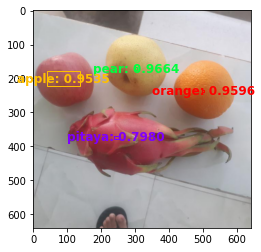

In [147]:
#讀取照片
#['fruit_type',income,cost]
prices = {
    0:['annona',83,60],
    1:['apple',159,59],
    2:['banana',21,6],
    3:['guava',77,37],
    4:['orange',49,19],
    5:['pear',37,12],
    6:['pineapple',87,42],  
    7:['pitaya',96,56]
}

fruits = run(56, display=True)
'''
#板子記憶體撐不住;-;
for i in range(0,total_images):
    fruits = run(i, display=True)
'''
#print(fruits)
total = 0
cost = 0
fruit = ""
present_quantity={}
for i in fruits:
    total += prices[i][1]
    fruit += prices[i][0] +'、'
    cost += prices[i][2]
    # 記錄售出的數量
    if i in sold_quantity:
        sold_quantity[i] += 1
    else:
        sold_quantity[i] = 1
    if i in present_quantity:
        present_quantity[i] += 1
    else:
        present_quantity[i] = 1
    qty = present_quantity[i]
    print("{} 有 {} 個 總價為 : {} 成本為 : {}".format(prices[i][0],qty,prices[i][1]*qty,prices[i][2]*qty ))
print("裡面有：{}\n總價為 : {}\n成本為 : {}".format(fruit,total,cost ))
#print(sold_quantity)
# 讀取原本的 CSV 檔案
input_file = "fruit_prices.csv"
df = pd.read_csv(input_file)

# 更新 DataFrame 中的數據
for fruit_type, quantity in sold_quantity.items():
    index = df.index[df['fruit'] == prices[fruit_type][0]].tolist()[0]
    #print(prices[fruit_type][0])
    df.at[index, 'income'] = prices[fruit_type][1]*quantity
    df.at[index, 'cost'] = prices[fruit_type][2]*quantity
    df.at[index, 'sold_num'] = quantity

# 將更新後的 DataFrame 寫回 CSV 檔案
df.to_csv('fruit_prices.csv', index=False)

print("更新後的結果已保存到 fruit_prices.csv")

In [ ]:
for i in fruits:
    print(i)
    fruit += prices[i][0] +'、'
print(fruit)

In [148]:
#目前售出水果個數
for fruit_type, quantity in sold_quantity.items():
    print(prices[fruit_type][0],end=' ')
    print(quantity)

pineapple 10
pear 14
guava 11
banana 4
apple 12
annona 3
pitaya 10
orange 9


In [ ]:
time1 = time.time()
[run(i) for i in range(total_images)]
time2 = time.time()
fps = total_images/(time2-time1)
print("Performance: {} FPS".format(fps))

We can also run it for multiple images as shown below. In this example
we have only used 1 thread; in principle, users should be able to boost
the performance by employing more threads.

In [ ]:
#淨收入初始化
total_income = 0
total_cost = 0
total_cost_single = 0
fruit_income = 0
fruit_cost=0
fruit_num = 0

In [149]:
def calculate_total_income_and_cost(csv_file):
    # 讀取 CSV 文件
    data = pd.read_csv(csv_file)
    
    # 計算 income 和 cost 的總和
    total_income = data['income'].sum()
    total_cost = data['cost'].sum()

    return total_income, total_cost
def calculate_kinds_of_fruits(csv_file):
    data = pd.read_csv(csv_file)
    for w,x,y,z in zip(data['fruit'],data['income'],data['cost'],data['sold_num']):
        print(f'{w} 共賣出 {z} 個,淨收入為 {x} 成本為{y} 利潤為{(x-y)}')

In [ ]:
使用攝影機

In [70]:
# Cpature an image from the camera
'''
frame_in_w = 640
frame_in_h = 640
videoIn = cv2.VideoCapture(1)
videoIn.set(cv2.CAP_PROP_FRAME_WIDTH, 640);
videoIn.set(cv2.CAP_PROP_FRAME_HEIGHT, 640);
print("capture device is open: " + str(videoIn.isOpened()))
_ , img = videoIn.read()
display = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(display)
plt.show()
'''

'\nframe_in_w = 640\nframe_in_h = 640\nvideoIn = cv2.VideoCapture(1)\nvideoIn.set(cv2.CAP_PROP_FRAME_WIDTH, 640);\nvideoIn.set(cv2.CAP_PROP_FRAME_HEIGHT, 640);\nprint("capture device is open: " + str(videoIn.isOpened()))\n_ , img = videoIn.read()\ndisplay = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)\nplt.imshow(display)\nplt.show()\n'

In [ ]:
#Testimg = np.array(pre_process(input_image, (640, 640)), dtype=np.float32)
#image_data = np.array(pre_process(input_image, (640, 640)), dtype=np.float32)


capture device is open: True


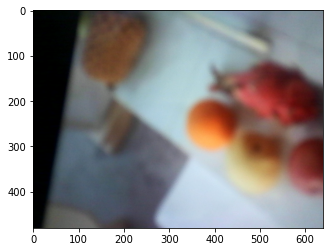

pitaya 有 1 個 總價為 : 96 成本為 : 56
pear 有 1 個 總價為 : 37 成本為 : 12
orange 有 1 個 總價為 : 49 成本為 : 19
apple 有 1 個 總價為 : 159 成本為 : 59
裡面有：pitaya、pear、orange、apple、
總價為 : 341
成本為 : 146
更新後的結果已保存到 fruit_prices.csv


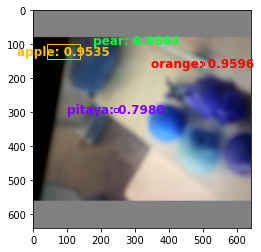

In [150]:
# Cpature an image from the camera
frame_in_w = 640
frame_in_h = 640
videoIn = cv2.VideoCapture(0)
videoIn.set(cv2.CAP_PROP_FRAME_WIDTH, frame_in_w );
videoIn.set(cv2.CAP_PROP_FRAME_HEIGHT, frame_in_h);
print("capture device is open: " + str(videoIn.isOpened()))
_ , img = videoIn.read()
display = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(display)
plt.show()

cam = run_cam(img,display=True)
total = 0
cost = 0
fruit = ""
present_quantity={}
for i in cam:
    total += prices[i][1]
    fruit += prices[i][0] +'、'
    cost += prices[i][2]
    # 記錄售出的數量
    if i in sold_quantity:
        sold_quantity[i] += 1
    else:
        sold_quantity[i] = 1
    if i in present_quantity:
        present_quantity[i] += 1
    else:
        present_quantity[i] = 1
    qty = present_quantity[i]
    print("{} 有 {} 個 總價為 : {} 成本為 : {}".format(prices[i][0],qty,prices[i][1]*qty,prices[i][2]*qty ))
print("裡面有：{}\n總價為 : {}\n成本為 : {}".format(fruit,total,cost ))
#print(sold_quantity)
# 讀取原本的 CSV 檔案
input_file = "fruit_prices.csv"
df = pd.read_csv(input_file)

# 更新 DataFrame 中的數據
for fruit_type, quantity in sold_quantity.items():
    index = df.index[df['fruit'] == prices[fruit_type][0]].tolist()[0]
    #print(prices[fruit_type][0])
    df.at[index, 'income'] = prices[fruit_type][1]*quantity
    df.at[index, 'cost'] = prices[fruit_type][2]*quantity
    df.at[index, 'sold_num'] = quantity

# 將更新後的 DataFrame 寫回 CSV 檔案
df.to_csv('fruit_prices.csv', index=False)

print("更新後的結果已保存到 fruit_prices.csv")
videoIn.release()

In [151]:
csv_file = 'fruit_prices.csv'  # CSV 文件的路徑
#所有樣本
print('-----所有樣本-----(❤️´艸｀❤️)')
calculate_kinds_of_fruits(csv_file)

total_income, total_cost = calculate_total_income_and_cost(csv_file)

-----所有樣本-----(❤️´艸｀❤️)
annona 共賣出 3 個,淨收入為 249 成本為180 利潤為69
apple 共賣出 13 個,淨收入為 2067 成本為767 利潤為1300
banana 共賣出 4 個,淨收入為 84 成本為24 利潤為60
guava 共賣出 11 個,淨收入為 847 成本為407 利潤為440
orange 共賣出 10 個,淨收入為 490 成本為190 利潤為300
pear 共賣出 15 個,淨收入為 555 成本為180 利潤為375
pineapple 共賣出 10 個,淨收入為 870 成本為420 利潤為450
pitaya 共賣出 11 個,淨收入為 1056 成本為616 利潤為440


In [152]:
print(f"淨收入: {total_income}")
print(f"總成本: {total_cost}")
sum = total_income -total_cost
print(f'總利潤: {sum}')

淨收入: 6218
總成本: 2784
總利潤: 3434


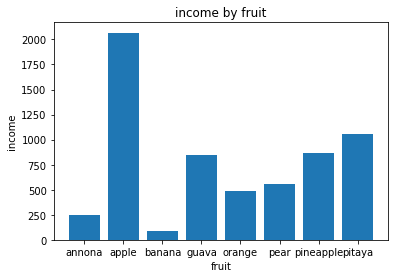

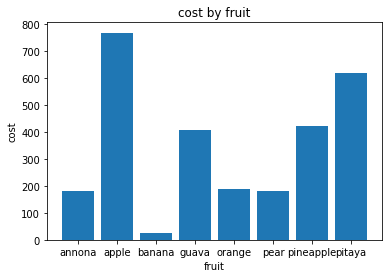

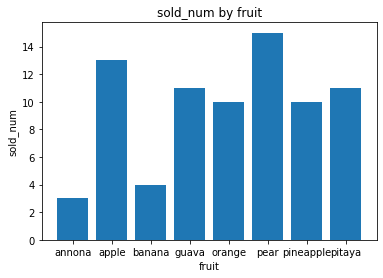

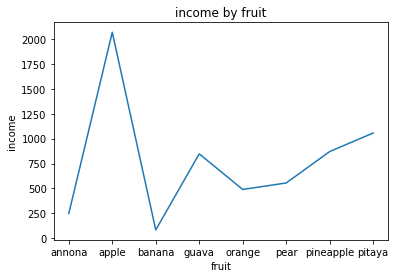

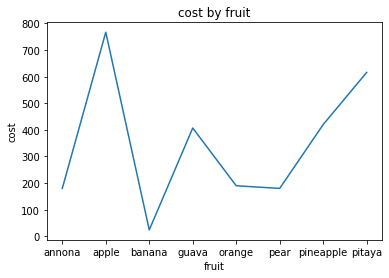

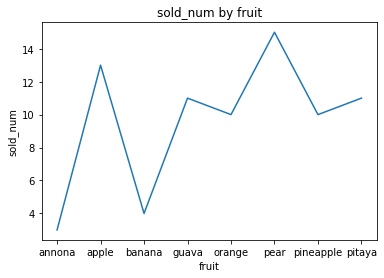

In [153]:
import pandas as pd
import matplotlib.pyplot as plt

# 繪製柱狀圖  
def plot_bar(df, x_col, y_col):
    plt.bar(df[x_col], df[y_col])
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title(f'{y_col} by {x_col}')
    
# 繪製線性圖
def plot_line(df, x_col, y_col):
    plt.plot(df[x_col], df[y_col])
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title(f'{y_col} by {x_col}')

df = pd.read_csv('fruit_prices.csv')
plot_bar(df, 'fruit', 'income')
plt.show()
plot_bar(df, 'fruit', 'cost')
plt.show()
plot_bar(df, 'fruit', 'sold_num')
plt.show()

plot_line(df, 'fruit', 'income')
plt.show()
plot_line(df, 'fruit', 'cost')
plt.show()
plot_line(df, 'fruit', 'sold_num')
plt.show()



We will need to remove references to `vart.Runner` and let Python garbage-collect
the unused graph objects. This will make sure we can run other notebooks without
any issue.

In [ ]:
#del overlay
#del dpu

----

Copyright (C) 2021 Xilinx, Inc

SPDX-License-Identifier: Apache-2.0 License

----

----